In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

In [68]:
# --- City and Ant Initialization ---
def create_city_grid(grid_size=100, n_homes=8, n_buildings=20, rng_key=jr.PRNGKey(0)):
    home_radius = grid_size // 2.5
    building_radius = grid_size // 6
    angles = jnp.linspace(0, 2 * jnp.pi, n_homes, endpoint=False)
    home_x = grid_size // 2 + home_radius * jnp.cos(angles)
    home_y = grid_size // 2 + home_radius * jnp.sin(angles)
    homes = jnp.stack([home_x, home_y], axis=1).astype(int)

    key1, key2 = jr.split(rng_key)
    building_angles = jr.uniform(key1, (n_buildings,), minval=0, maxval=2*jnp.pi)
    building_radii = jr.uniform(key2, (n_buildings,), minval=0, maxval=building_radius)
    building_x = grid_size // 2 + building_radii * jnp.cos(building_angles)
    building_y = grid_size // 2 + building_radii * jnp.sin(building_angles)
    buildings = jnp.stack([building_x, building_y], axis=1).astype(int)
    return homes, buildings

def initialize_ants(homes, ants_per_home, n_buildings, rng_key):
    n_homes = homes.shape[0]
    n_ants = n_homes * ants_per_home
    home_indices = jnp.repeat(jnp.arange(n_homes), ants_per_home)
    ant_positions = homes[home_indices]
    ant_states = jnp.zeros(n_ants, dtype=int)  # 0: searching, 1: returning
    # Each ant randomly picks a building as its food source
    ant_targets = jr.randint(rng_key, (n_ants,), 0, n_buildings)
    return ant_positions, home_indices, ant_states, ant_targets

def get_neighbors(pos, grid_size):
    x, y = pos
    neighbors = jnp.array([
        [(x+1)%grid_size, y],
        [(x-1)%grid_size, y],
        [x, (y+1)%grid_size],
        [x, (y-1)%grid_size]
    ])
    return neighbors

# --- Ant Step ---
def ant_step(
    ant_positions, ant_states, ant_targets, home_indices, homes, buildings,
    pheromone_grid_0, pheromone_grid_1, alpha, beta, rng_key
):
    grid_size = pheromone_grid_0.shape[0]
    n_ants = ant_positions.shape[0]

    def move_ant(i, pos_state):
        pos, state = pos_state
        target = ant_targets[i]
        home = homes[home_indices[i]]
        dest = jax.lax.cond(state == 0, lambda _: buildings[target], lambda _: home, operand=None)
        neighbors = get_neighbors(pos, grid_size)
        dists = jnp.linalg.norm(neighbors - dest, axis=1)
        eta = 1.0 / (dists + 1e-8)
        # Use the *opposite* pheromone grid for attraction
        tau = jax.lax.cond(
            state == 0,
            lambda _: pheromone_grid_1[neighbors[:,0], neighbors[:,1]],
            lambda _: pheromone_grid_0[neighbors[:,0], neighbors[:,1]] + pheromone_grid_1[neighbors[:,0], neighbors[:,1]],
            operand=None
        )
        tau = tau + 1e-6 
        probs = (tau ** alpha) * (eta ** beta)
        probs = probs / jnp.sum(probs)
        key = jr.fold_in(rng_key, i)
        idx = jr.choice(key, 4, p=probs)
        new_pos = neighbors[idx]
        reached = jnp.all(new_pos == dest)
        new_state = jax.lax.cond(reached, lambda _: 1-state, lambda _: state, operand=None)
        return (new_pos, new_state)

    new_positions, new_states = jax.vmap(move_ant, in_axes=(0, 0))(
        jnp.arange(n_ants), (ant_positions, ant_states)
    )
    return new_positions, new_states

def update_pheromones(pheromone_grid_0, pheromone_grid_1, ant_positions, prev_positions, ant_states, rho=0.1, Q=1.0):
    pheromone_grid_0 = (1 - rho) * pheromone_grid_0
    pheromone_grid_1 = (1 - rho) * pheromone_grid_1
    # Deposit pheromone on the grid corresponding to the ant's state
    for prev, curr, state in zip(prev_positions, ant_positions, ant_states):
        pheromone_grid_0 = jax.lax.cond(
            state == 0,
            lambda grid: grid.at[curr[0], curr[1]].add(Q),
            lambda grid: grid,
            pheromone_grid_0
        )
        pheromone_grid_1 = jax.lax.cond(
            state == 1,
            lambda grid: grid.at[curr[0], curr[1]].add(Q),
            lambda grid: grid,
            pheromone_grid_1
        )
    return pheromone_grid_0, pheromone_grid_1

# --- Simulation Loop ---
def run_simulation_scan(
    grid_size=100, n_homes=8, n_buildings=10, ants_per_home=50, steps=200,
    alpha=1.0, beta=2.0, rho=0.001, Q=1.0, rng_key=jr.PRNGKey(42)
):
    homes, buildings = create_city_grid(grid_size, n_homes, n_buildings, rng_key=rng_key)
    ant_positions, home_indices, ant_states, ant_targets = initialize_ants(homes, ants_per_home, n_buildings, rng_key)
    pheromone_grid_0 = jnp.zeros((grid_size, grid_size))  # deposited by state 0 ants
    pheromone_grid_1 = jnp.zeros((grid_size, grid_size))  # deposited by state 1 ants

    def scan_step(carry, t):
        ant_positions, ant_states, ant_targets, pheromone_grid_0, pheromone_grid_1, rng_key = carry
        prev_positions = ant_positions
        step_key = jr.fold_in(rng_key, t)
        # Ants in state 0 are attracted to pheromone_grid_1, and vice versa
        new_positions, new_states = ant_step(
            ant_positions, ant_states, ant_targets, home_indices, homes, buildings,
            pheromone_grid_0, pheromone_grid_1, alpha, beta, step_key
        )
        pheromone_grid_0_new, pheromone_grid_1_new = update_pheromones(
            pheromone_grid_0, pheromone_grid_1, new_positions, prev_positions, new_states, rho, Q
        )
        reached_food = (new_states == 1) & jnp.all(new_positions == buildings[ant_targets], axis=1)
        new_targets = jr.randint(jr.fold_in(rng_key, t+1000), (new_positions.shape[0],), 0, n_buildings)
        ant_targets_new = jnp.where(reached_food, new_targets, ant_targets)
        return (
            (new_positions, new_states, ant_targets_new, pheromone_grid_0_new, pheromone_grid_1_new, rng_key),
            (new_positions, pheromone_grid_0_new, pheromone_grid_1_new)
        )

    carry_init = (ant_positions, ant_states, ant_targets, pheromone_grid_0, pheromone_grid_1, rng_key)
    (final_carry, history) = jax.lax.scan(scan_step, carry_init, jnp.arange(steps))
    ant_positions_hist, pheromone_hist_0, pheromone_hist_1 = history
    return homes, buildings, ant_positions_hist, pheromone_hist_0, pheromone_hist_1

In [69]:
homes, buildings, ant_positions_hist, pheromone_hist_0, pheromone_hist_1 = run_simulation_scan(grid_size=200, steps=10000)
final_positions = ant_positions_hist[-1]
final_pheromone = pheromone_hist_0[-1] + pheromone_hist_1[-1]  # or plot separately

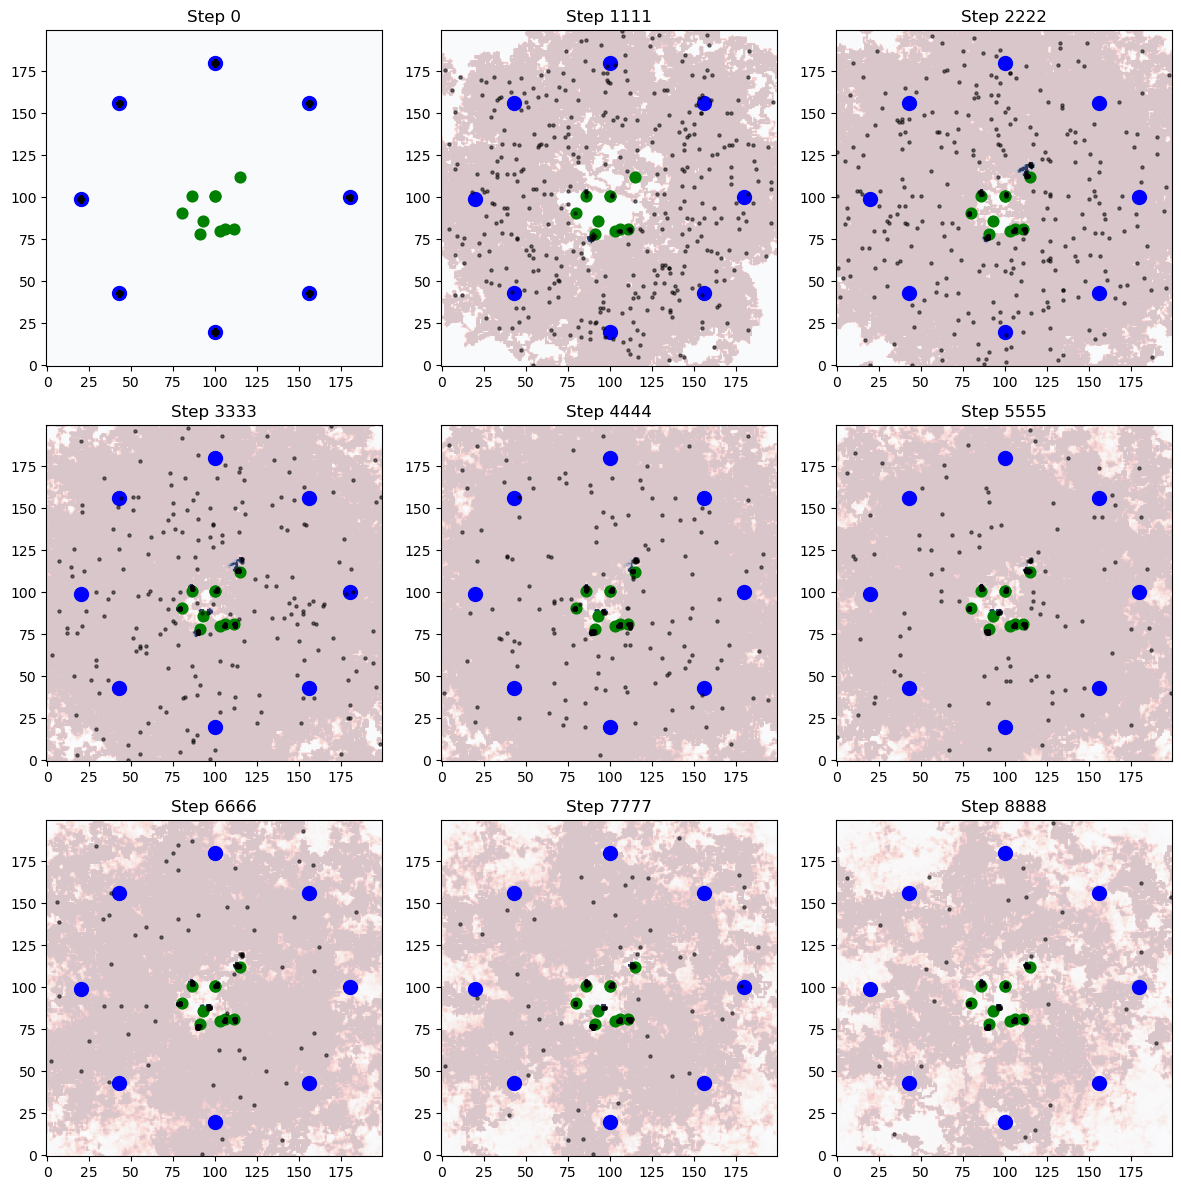

In [70]:
# Show 9 different, equally distributed points in the simulation
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
intervals = len(ant_positions_hist) // 9
for i in range(3):
    for j in range(3):
        idx = (i * 3 + j) * intervals
        ax = axs[i, j]
        ax.imshow(pheromone_hist_0[idx].T, origin='lower', cmap='Reds', alpha=0.7, vmax=0.8)
        ax.imshow(pheromone_hist_1[idx].T, origin='lower', cmap='Blues', alpha=0.7, vmax=0.8)
        ax.scatter(homes[:,0], homes[:,1], c='blue', s=100, label='Homes')
        ax.scatter(buildings[:,0], buildings[:,1], c='green', s=60, label='Buildings')
        ax.scatter(ant_positions_hist[idx][:,0], ant_positions_hist[idx][:,1], c='black', s=5, alpha=0.5, label='Ants')
        ax.set_title(f"Step {idx}")
        # ax.legend()
plt.tight_layout()
plt.show()